# In the US from 1999 to 2015, were legal teams featuring greater proportions of female lawyers more or less likely to forum shop in patent law cases? 

# Introduction

Brief introduction
Write a brief introduction of your project (two to four para-
graphs), the source of the data, and the important background necessary to un-
derstand your project (Keep it short. You will complete it over time). An outsider
should be able to understand what you are trying to do in this project. You should
state your data and its source, discuss your research question, and briefly mention
your findings. You should have at least five citations with one of them as your
main paper, and that paper should be the closest paper to your work. The citation
should show up in your references section as well in APA or Chicago style

## Set-up

In [83]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import gc
from sklearn.linear_model import LinearRegression

# make head display all columns instead of truncting
pd.set_option('display.max_columns', None)

Cases data

In [5]:
# call cases data to jupyter notebook
cases = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/cases.csv")
cases = cases.sort_values("case_name", ascending=True)

### prepare the cases dataset for merging

# create year variable
cases["year_filed"] = cases["case_number"].str.split(":").str[1].str[:2].astype(float)
cases.loc[cases.year_filed > 17, "year_filed"] = cases["year_filed"] + 1900
cases.loc[cases.year_filed < 17, "year_filed"] = cases["year_filed"] + 2000
cases["year_filed"] = cases["year_filed"].fillna(0).astype(float)

# these observations don't have a properly formatted case number
cases = cases.drop(index=[0, 1885, 1886])

# create case order variable (indicates 1 more than the number of cases that the court received before that case in that year)
cases["case_order"] = cases["case_number"].str.split(":").str[1]
cases["case_order"] = cases["case_order"].str.split("-").str[2].astype(float)

# create variable showing the courthouse within the district that received the case
cases["courthouse"] = cases["case_number"].str.split(":").str[0]

# standardize the court name variable so that it can be merged
cases["court_name"] = cases["court_name"].str.title()

# adjust these two specific values
cases["court_name"] = cases["court_name"].str.replace("U.S. District Court (Spokane)", "Eastern District Of Washington")
cases["court_name"] = cases["court_name"].str.replace("U.S. District Court (7)", "7th Court of Appeals")

# create region variable
cases.loc[cases.court_name.str.contains("Eastern"), "court_region"] = "Eastern"
cases.loc[cases.court_name.str.contains("Southern"), "court_region"] = "Southern"
cases.loc[cases.court_name.str.contains("Western"), "court_region"] = "Western"
cases.loc[cases.court_name.str.contains("Northern"), "court_region"] = "Northern"
cases["court_region"] = cases["court_region"].fillna("None")

# create state variable
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District Of Columbia", "Delaware", 
          "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", 
          "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", 
          "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", 
          "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", 
          "Wisconsin", "West Virginia", "Wyoming", "7th"]

for state in state_names:
    cases.loc[cases.court_name.str.contains(state), "court_state"] = state

# process demand variable to get rid of non-numeric values
cases["demand"] = cases["demand"].astype(str)
cases.loc[False == cases.demand.str.strip().str.isalpha(), "demand_num"] = cases["demand"]
cases["demand_num"] = cases["demand_num"].str.replace("$", "")
cases["demand_num"] = cases["demand_num"].str.replace(",", "")
cases["demand_num"] = cases["demand_num"].astype(float)

cases.loc[cases.demand.str.strip().str.isalpha(), "demand_party"] = cases["demand"]
cases["demand_party"] = cases["demand_party"].astype(str)
cases["demand_party"] = cases["demand_party"].str.replace("p", "Plaintiff")
cases.loc[cases.demand_party == "P", "demand_party"] = str("Plaintiff")
cases.loc[cases.demand_party == "y", "demand_party"] = np.nan
cases.loc[cases.demand_party == "Y", "demand_party"] = np.nan
cases.loc[cases.demand_party == "nan", "demand_party"] = np.nan
# check you only have the values you desire
cases["demand_party"].unique()

# check for missing values
cases.isna().sum()

case_row_id                 0
case_number                 0
pacer_id                65076
case_name                 198
court_name                  0
assigned_to              2202
referred_to             47699
case_cause               3050
jurisdictional_basis     1897
demand                      0
jury_demand             67675
lead_case               71620
related_case            59695
settlement              74298
date_filed              65119
date_closed             65497
date_last_filed         71614
year_filed                  0
case_order                  0
courthouse                  0
court_region                0
court_state                 0
demand_num              74343
demand_party            23127
dtype: int64

In [464]:
# call pacer_cases data to jupyter notebook
pacer_cases = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/pacer_cases.csv")
pacer_cases = pacer_cases.sort_values("case_name", ascending=True)

# prepare the pacer_cases dataset for merging

# construct year variable
pacer_cases["year_filed"] = pacer_cases["case_number"].str.split(":").str[1].str[:4]
pacer_cases.loc[False == pacer_cases["year_filed"].str.isnumeric(), "year_filed"] = pacer_cases["year_filed"].str[:2].astype(float) + 2000
pacer_cases["year_filed"] = pacer_cases["year_filed"].fillna(0).astype(int)
# NOTE: 0 indicates NaN, 56 values

# construct case order (-1 indicates the number of cases that the court received before that case in that year)
pacer_cases["case_order"] = pacer_cases["case_number"].str.split(":").str[1]
pacer_cases["case_order"] = pacer_cases["case_order"].str.split("-").str[2]
pacer_cases.loc[False == pacer_cases["case_order"].str.isnumeric(), "case_order"] = pacer_cases["case_order"].str.split(".").str[0]
pacer_cases.loc[False == pacer_cases["case_order"].str.isnumeric(), "case_order"] = pacer_cases["case_order"].str[:5]
pacer_cases["case_order"] = pacer_cases["case_order"].astype(float)

# indicates the courthouse within the district that received the case
pacer_cases["courthouse"] = pacer_cases["case_number"].str.split(":").str[0]

# standardize the court name variable so that it can be merged
pacer_cases["court_name"] = pacer_cases["court_name"].str.title()
pacer_cases["court_name"] = pacer_cases["court_name"].str.split("(").str[0]

# create region variable
pacer_cases.loc[pacer_cases.court_name.str.contains("Eastern"), "court_region"] = "Eastern"
pacer_cases.loc[pacer_cases.court_name.str.contains("Southern"), "court_region"] = "Southern"
pacer_cases.loc[pacer_cases.court_name.str.contains("Western"), "court_region"] = "Western"
pacer_cases.loc[pacer_cases.court_name.str.contains("Northern"), "court_region"] = "Northern"
pacer_cases["court_region"] = pacer_cases["court_region"].fillna("None")

# create state variable
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District Of Columbia", "Delaware", 
          "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", 
          "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", 
          "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", 
          "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", 
          "Wisconsin", "West Virginia", "Wyoming", "7th"]

for state in state_names:
    pacer_cases.loc[pacer_cases.court_name.str.contains(state), "court_state"] = state

# check for missing values
pacer_cases.isna().sum()
pacer_cases[pacer_cases["case_order"].isna()]
# for 76 rows, the pacer dataset doesn't have a valid case number 

,case_name,court_code,court_name,date_closed,case_number,pacer_id,date_filed,year_filed,case_order,courthouse,court_region,court_state
56071,<b>CASE NUMBER NOT USED</b>,wawd,Washington Western District Court,07/09/2014,<b>CASE NUMBER NOT USED</b>,201976,2014-07-08,0,NaN,<b>CASE NUMBER NOT USED</b>,Western,Washington
38187,<b>DO NOT DOCKET IN THIS CASE - FILE CONSOLIDA...,prd,Puerto Rico District Court,NaN,<b>DO NOT DOCKET IN THIS CASE - FILE CONSOLIDA...,116270,2015-03-25,0,NaN,<b>DO NOT DOCKET IN THIS CASE - FILE CONSOLIDA...,None,Puerto Rico
31710,<font color=red> DO NOT DOCKET. CASE HAS BEEN ...,mnd,Minnesota District Court,03/15/2011,"<font color=""red""> DO NOT DOCKET. CASE HAS BEE...",116638,2010-10-14,0,NaN,"<font color=""red""> DO NOT DOCKET. CASE HAS BEE...",None,Minnesota
57150,<font color=red>**CASE CLOSED-ALL ENTRIES MUST...,mied,Michigan Eastern District Court,10/07/2010,"<font color=""red"">**CASE CLOSED-ALL ENTRIES MU...",246723,2010-02-26,0,NaN,"<font color=""red"">**CASE CLOSED-ALL ENTRIES MU...",Eastern,Michigan
63523,<font color=red>**CASE CLOSED-ALL ENTRIES MUST...,mied,Michigan Eastern District Court,12/24/2013,"<font color=""red"">**CASE CLOSED-ALL ENTRIES MU...",273338,2012-09-11,0,NaN,"<font color=""red"">**CASE CLOSED-ALL ENTRIES MU...",Eastern,Michigan
...,...,...,...,...,...,...,...,...,...,...,...,...
59697,Wacoh Company v. Chrysler LLC et al <font colo...,mied,Michigan Eastern District Court,02/25/2009,"<font color=""red"">**CASE CLOSED - ALL ENTRIES ...",236151,2009-01-12,0,NaN,"<font color=""red"">**CASE CLOSED - ALL ENTRIES ...",Eastern,Michigan
73253,"Walters v. ROSECO, INC. <B><font color=red>Do ...",txsd,Texas Southern District Court,12/05/2011,"<b><font color=""red"">Do Not Docket in 4:11cv15...",882961,2011-04-21,2011,NaN,"<b><font color=""red"">Do Not Docket in 4",Southern,Texas
40269,"WhatRU Holding, LLC v. Bouncing Angels, Inc. e...",mnd,Minnesota District Court,07/01/2014,"<font color=""red"">DO NOT DOCKET. CASE HAS BEEN...",134295,2013-10-04,0,NaN,"<font color=""red"">DO NOT DOCKET. CASE HAS BEEN...",None,Minnesota
65100,"comScore, Inc. v. DoubleVerify Inc.<font color...",vaed,Virginia Eastern District Court,10/28/2013,"<font color=""purple"">DO NOT FILE IN THIS CASE....",283004,2012-07-20,2012,NaN,"<font color=""purple"">DO NOT FILE IN THIS CASE....",Eastern,Virginia


In [496]:
# merge
m_cases = pd.merge(cases, pacer_cases, on=["year_filed", "case_order", "courthouse", "court_region", "court_state"], how="left")

# fill in missing values from the cases dataset using the pacer_cases dataset
m_cases["case_name_x"] = m_cases["case_name_x"].fillna(m_cases["case_name_y"])
m_cases["date_filed_x"] = m_cases["date_filed_x"].fillna(m_cases["date_filed_y"])
m_cases["date_closed_x"] = m_cases["date_closed_x"].fillna(m_cases["date_filed_y"])

# check for missing values
m_cases.isna().sum()

# group dataset by whether the year is before or after 1999
m_cases.loc[m_cases.year_filed >= 1999, "post_99"] = 1
m_cases.loc[m_cases.year_filed < 1999, "post_99"] = 0
grouped_cases = m_cases.groupby(by="post_99")

# convert dates to date format
m_cases["date_filed"] = pd.to_datetime(m_cases["date_filed_x"])
m_cases["date_closed"] = pd.to_datetime(m_cases["date_closed_x"])
m_cases["date_last_filed"] = pd.to_datetime(m_cases["date_last_filed"])

# drop superfluous variables
m_cases = m_cases.drop(columns=["date_filed_x", "date_closed_x", "case_name_y", "court_name_y", "date_closed_y", "case_number_y", 
                                "pacer_id_y", "date_filed_y"])

# make a subset of the dataset with just the cases since 1999
cases_99 = m_cases.drop(m_cases[m_cases["post_99"] != 1].index)

# list(cases_99["case_cause"].unique())

# create a binary variable indicating whether a case involves patent infringement
cases_99["case_cause"] = cases_99["case_cause"].str.lower()
cases_99["case_cause"] = cases_99["case_cause"].str.strip()
cases_99.loc[cases_99.case_cause.str.contains("infringement of patent", na=False), "patent_infringement"] = 1
cases_99.loc[cases_99.case_cause.str.contains("patent infringement", na=False), "patent_infringement"] = 1
cases_99["patent_infringement"] = cases_99["patent_infringement"].fillna(0)

list(cases_99["case_cause"].unique())
cases_99["patent_infringement"].value_counts()

patent_infringement
1.0    50154
0.0     8488
Name: count, dtype: int64

Attorneys Data

In [582]:
# call data to jupyter notebook
attorneys = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys.csv")
gender = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/wgnd_2_0_name-gender_nocode.csv")

# fill (See above for address) using above
attorneys["contactinfo"] = attorneys["contactinfo"].fillna(0)
attorneys["contactinfo"] = attorneys["contactinfo"].str.strip()
attorneys["contactinfo"] = attorneys["contactinfo"].replace('(See above for address)', np.nan)
attorneys["contactinfo"] = attorneys["contactinfo"].ffill()

# download dataset, extract zip code using excel - downloaded in parts to avoid excel row limit 
# BUT doesn't work bc I need it to be able to tell if something is a letter or a number :(
attorneys.iloc[:80000, :].to_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys_pd1.csv", index=False)
attorneys.iloc[80000:, :].to_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys_pd2.csv", index=False)

In [588]:
import re
value = "Collins and Lacy; PO Box 12487; Columbia, SC 29211; 803-256-2660; Fax: 803-771-4484; Email: jcollins@collinsandlacy.com"
result = re.findall(", [a-zA-Z][a-zA-Z] \d\d\d\d\d", value)
print(result)
# figure out how this works - https://www.w3schools.com/python/python_regex.asp 

[', SC 29211']


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\schwa\AppData\Local\Temp\ipykernel_22640\2491407068.py:3: SyntaxWarning: invalid escape sequence '\d'
  result = re.findall(", [a-zA-Z][a-zA-Z] \d\d\d\d\d", value)


In [ ]:
# reupload dataset


# collapse dataset so that there's only one entry per attorney per case
attorneys = attorneys.groupby(["case_row_id", "name"]).agg("first")
attorneys = attorneys.reset_index()

# create variable w first name
attorneys["first_name"] = attorneys["name"].str.split().str[0].str.lower().astype(str)

# merge with gender dataset, drop the dataset
attorneys = attorneys.merge(gender, left_on="first_name", right_on="name", how="left")
del [gender]
gc.collect()
gender = pd.DataFrame()

attorneys
attorneys.isna().sum()

In [549]:
missing_attorneys = attorneys[attorneys["gender"].isna()]
missing_attorneys = missing_attorneys[missing_attorneys["name_x"].isna() == False]

# merge with dataset with gender names for US
gender = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/wgnd_2_0_name-gender-code_US_likely.csv")
missing_attorneys = missing_attorneys.merge(gender, left_on="first_name", right_on="name",how="left")
missing_attorneys.isna().sum()

# drop variables so you can concat the missing_attorneys dataset with the attorneys dataset
missing_attorneys["name_y"] = missing_attorneys["name"]
missing_attorneys["gender"] = missing_attorneys["gender_y"]
missing_attorneys = missing_attorneys.drop(["name", "gender_y", "gender_x"], axis= 1)

# drop missing values from the attorneys dataset, add back the missing_attorneys
attorneys = attorneys[attorneys["gender"].isna() == False]
attorneys = pd.concat([attorneys, missing_attorneys], axis = 0)
attorneys.isna().sum()

case_row_id               0
name_x                    0
case_number               0
party_row_count           0
party_type                0
attorney_row_count        0
contactinfo             108
position              14452
first_name                0
name_y                24295
gender                24295
dtype: int64

In [516]:
# use to see the possible values for party type
# list(attorneys["party_type"].unique())

In [550]:
# label each attorney either defendent, plantiff, garnishee, mediator, witness, or other
list(attorneys["party_type"].unique())
attorneys["party_type"] = attorneys["party_type"].str.lower()

attorneys.loc[attorneys.party_type.str.contains("defendant"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("respondent"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("counter claimant"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("dft"), "defendant"] = 1
attorneys.loc[attorneys.party_type.str.contains("plaintiff"), "plaintiff"] = 1
attorneys.loc[attorneys.party_type.str.contains("mediator"), "mediator"] = 1
attorneys.loc[attorneys.party_type.str.contains("witness"), "witness"] = 1
attorneys.loc[attorneys.party_type.str.contains("deponent"), "witness"] = 1

attorneys.loc[attorneys.defendant.isna(), "other"] = 1
attorneys.loc[attorneys.plaintiff.isna() == False, "other"] = 0
attorneys.loc[attorneys.mediator.isna() == False, "other"] = 0
attorneys.loc[attorneys.witness.isna() == False, "other"] = 0
attorneys.loc[attorneys.position.isna() == False, "other"] = 0

# create gendered variables for each attorney category
attorneys.loc[(attorneys["defendant"] == 1)&(attorneys["gender"] == "M"), "defendant_M"] = 1
attorneys.loc[(attorneys["defendant"] == 1)&(attorneys["gender"] == "F"), "defendant_F"] = 1
attorneys.loc[(attorneys["plaintiff"] == 1)&(attorneys["gender"] == "M"), "plaintiff_M"] = 1
attorneys.loc[(attorneys["plaintiff"] == 1)&(attorneys["gender"] == "F"), "plaintiff_F"] = 1
attorneys.loc[(attorneys["mediator"] == 1)&(attorneys["gender"] == "M"), "mediator_M"] = 1
attorneys.loc[(attorneys["mediator"] == 1)&(attorneys["gender"] == "F"), "mediator_F"] = 1
attorneys.loc[(attorneys["witness"] == 1)&(attorneys["gender"] == "M"), "witness_M"] = 1
attorneys.loc[(attorneys["witness"] == 1)&(attorneys["gender"] == "F"), "witness_F"] = 1
attorneys.loc[(attorneys["other"] == 1)&(attorneys["gender"] == "M"), "other_M"] = 1
attorneys.loc[(attorneys["other"] == 1)&(attorneys["gender"] == "F"), "other_F"] = 1

attorneys.loc[attorneys["gender"] == "M", "male"] = 1
attorneys.loc[attorneys["gender"] == "F", "female"] = 1
attorneys["total"] = 1

attorneys.head(20)

,case_row_id,name_x,case_number,party_row_count,party_type,attorney_row_count,contactinfo,position,first_name,name_y,gender,defendant,plaintiff,mediator,witness,other,defendant_M,defendant_F,plaintiff_M,plaintiff_F,mediator_M,mediator_F,witness_M,witness_F,other_M,other_F,male,female,total
0,14,Edwin Russell Jeter,0:92-cv-00398-MJP,45,defendant,6,"Jeter and Williams; PO Box 7425; Columbia, SC 29202; 803-765-0600; Fax: 803-765-0619; Email: ejeter@jeterandwilliams.com",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,edwin,edwin,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
1,14,"Joel Wyman Collins , Jr",0:92-cv-00398-MJP,40,plaintiff,1,"Collins and Lacy; PO Box 12487; Columbia, SC 29211; 803-256-2660; Fax: 803-771-4484; Email: jcollins@collinsandlacy.com",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,joel,joel,M,NaN,1.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
2,14,John Edward Cuttino,0:92-cv-00398-MJP,45,defendant,7,"Gallivan White and Boyd; PO Box 7368; Columbia, SC 29202; 803-724-1714; Fax: 803-779-1767; Email: jcuttino@gwblawfirm.com",TERMINATED: 03/17/1994; LEAD ATTORNEY; ATTORNEY TO BE NOTICED,john,john,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
3,14,Paul L Gardner,0:92-cv-00398-MJP,45,defendant,8,"Spensley Horn Jubas and Lubitz; 1880 Century Park East; Suite 500; Los Angeles, CA 90069; 310/553-5050",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,paul,paul,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
4,14,R Bentz Kirby,0:92-cv-00398-MJP,45,defendant,9,"Glenn Walters Law Firm; PO Box 1346; Orangeburg, SC 29116; 803-531-8844; Fax: 803-531-3628; Email: bentz.kirby@earthlink.net",TERMINATED: 06/05/1992; LEAD ATTORNEY; ATTORNEY TO BE NOTICED,r,r,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
5,38,Aaron Samuel Podhurst,0:89-cv-06934-NCR,119,defendant,39,"Podhurst Orseck, P.A.; City National Bank Building; 25 W Flagler Street; Suite 800; Miami, FL 33130-1780; 305-358-2800; Fax: 305-358-2382; Email: apodhurst@podhurst.com",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,aaron,aaron,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
6,38,Arnold A. Pagniucci,0:89-cv-06934-NCR,119,defendant,45,"Sachnoff & Weaver; 10 S Wacker Drive; 40th Floor; Chicago, IL 60606; 312-207-1000",ATTORNEY TO BE NOTICED,arnold,arnold,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
7,38,Daniel R. Cherry,0:89-cv-06934-NCR,119,defendant,40,"Welsh & Katz; 120 S Riverside Plaza; 22nd Floor; Chicago, IL 60606; 312-655-1500",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,daniel,daniel,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
8,38,David Berten,0:89-cv-06934-NCR,118,plaintiff,26,"Bartlit Beck Herman Palenchar & Scott; 54 W Hubbard Street; Suite 300; Chicago, IL 60610; 312-494-4444",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,david,david,M,NaN,1.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
9,38,Dennis Alan Richard,0:89-cv-06934-NCR,119,defendant,41,"Richard & Richard; 825 Brickell Bay Drive; Suite 1748 Tower III; Miami, FL 33131-2961; 305-374-6688; Fax: 374-0384; Email: dennis@richardandrichard.com",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,dennis,dennis,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1


In [554]:
pd.set_option('display.max_colwidth', None)

# fill (See above for address) using above
attorneys["contactinfo"] = attorneys["contactinfo"].fillna(0)
attorneys["contactinfo"] = attorneys["contactinfo"].str.strip()
attorneys["contactinfo"] = attorneys["contactinfo"].replace('(see above for address)', np.nan)
attorneys["contactinfo"] = attorneys["contactinfo"].ffill()

# split contactinfo
attorneys["contactinfo"]

# use split data to save 5 digit number followed by ; (must somehow account for PO boxes? last 5 digits) or 5digits-4digits 
# , 2letters 5digits

attorneys.head(10)

,case_row_id,name_x,case_number,party_row_count,party_type,attorney_row_count,contactinfo,position,first_name,name_y,gender,defendant,plaintiff,mediator,witness,other,defendant_M,defendant_F,plaintiff_M,plaintiff_F,mediator_M,mediator_F,witness_M,witness_F,other_M,other_F,male,female,total
0,14,Edwin Russell Jeter,0:92-cv-00398-MJP,45,defendant,6,"Jeter and Williams; PO Box 7425; Columbia, SC 29202; 803-765-0600; Fax: 803-765-0619; Email: ejeter@jeterandwilliams.com",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,edwin,edwin,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
1,14,"Joel Wyman Collins , Jr",0:92-cv-00398-MJP,40,plaintiff,1,"Collins and Lacy; PO Box 12487; Columbia, SC 29211; 803-256-2660; Fax: 803-771-4484; Email: jcollins@collinsandlacy.com",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,joel,joel,M,NaN,1.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
2,14,John Edward Cuttino,0:92-cv-00398-MJP,45,defendant,7,"Gallivan White and Boyd; PO Box 7368; Columbia, SC 29202; 803-724-1714; Fax: 803-779-1767; Email: jcuttino@gwblawfirm.com",TERMINATED: 03/17/1994; LEAD ATTORNEY; ATTORNEY TO BE NOTICED,john,john,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
3,14,Paul L Gardner,0:92-cv-00398-MJP,45,defendant,8,"Spensley Horn Jubas and Lubitz; 1880 Century Park East; Suite 500; Los Angeles, CA 90069; 310/553-5050",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,paul,paul,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
4,14,R Bentz Kirby,0:92-cv-00398-MJP,45,defendant,9,"Glenn Walters Law Firm; PO Box 1346; Orangeburg, SC 29116; 803-531-8844; Fax: 803-531-3628; Email: bentz.kirby@earthlink.net",TERMINATED: 06/05/1992; LEAD ATTORNEY; ATTORNEY TO BE NOTICED,r,r,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
5,38,Aaron Samuel Podhurst,0:89-cv-06934-NCR,119,defendant,39,"Podhurst Orseck, P.A.; City National Bank Building; 25 W Flagler Street; Suite 800; Miami, FL 33130-1780; 305-358-2800; Fax: 305-358-2382; Email: apodhurst@podhurst.com",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,aaron,aaron,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
6,38,Arnold A. Pagniucci,0:89-cv-06934-NCR,119,defendant,45,"Sachnoff & Weaver; 10 S Wacker Drive; 40th Floor; Chicago, IL 60606; 312-207-1000",ATTORNEY TO BE NOTICED,arnold,arnold,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
7,38,Daniel R. Cherry,0:89-cv-06934-NCR,119,defendant,40,"Welsh & Katz; 120 S Riverside Plaza; 22nd Floor; Chicago, IL 60606; 312-655-1500",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,daniel,daniel,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
8,38,David Berten,0:89-cv-06934-NCR,118,plaintiff,26,"Bartlit Beck Herman Palenchar & Scott; 54 W Hubbard Street; Suite 300; Chicago, IL 60610; 312-494-4444",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,david,david,M,NaN,1.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
9,38,Dennis Alan Richard,0:89-cv-06934-NCR,119,defendant,41,"Richard & Richard; 825 Brickell Bay Drive; Suite 1748 Tower III; Miami, FL 33131-2961; 305-374-6688; Fax: 374-0384; Email: dennis@richardandrichard.com",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,dennis,dennis,M,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1


In [13]:
# aggregate to create one row per case
c_attorneys = attorneys.groupby("case_row_id").agg("sum")

c_attorneys = c_attorneys.fillna(0)
c_attorneys = c_attorneys.drop(c_attorneys.iloc[:, 0:9], axis=1)
c_attorneys.head(10)

,defendant,plaintiff,mediator,witness,other,defendant_M,defendant_F,plaintiff_M,plaintiff_F,mediator_M,mediator_F,witness_M,witness_F,other_M,other_F,male,female,total
case_row_id,,,,,,,,,,,,,,,,,,
14,4.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5
38,9.0,13.0,0.0,0.0,0.0,8.0,1.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,2.0,22
39,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2
40,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2
41,1.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3
43,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2
45,1.0,4.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5
46,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
47,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


Documents data

In [170]:
# call data to jupyter notebook
documents = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/documents.csv", low_memory=False)

# clean
documents["number_docs"] = 1
doc_agg = documents.groupby("case_row_id").agg("sum")

doc_agg.head(10)

,case_number,doc_count,attachment,date_filed,long_description,doc_number,short_description,upload_date,number_docs
case_row_id,,,,,,,,,
1,0:79-cv-06704-JCP0:79-cv-06704-JCP,3,0.0,2000-08-031982-05-31,"COPY OF PAPER DOCKET SHEET (kw, Deputy Clerk) ...",37,0,0,2
3,0:83-cv-06860-JAG0:83-cv-06860-JAG0:83-cv-0686...,15,0.0,2004-02-131992-03-011990-10-161987-07-221987-0...,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,12394,0,0,5
4,0:84-cv-06456-KLR,1,0.0,2004-01-16,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,123,0,0,1
5,0:84-cv-06726-WMH0:84-cv-06726-WMH0:84-cv-0672...,10,0.0,2003-11-212003-11-211991-03-291991-03-29,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,3421,0,0,4
6,0:85-cv-06225-TES,1,0.0,2003-10-22,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,123,0,0,1
7,0:85-cv-06368-JCP,1,0.0,2003-10-10,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,81,0,0,1
8,0:85-cv-06452-WJZ,1,0.0,2003-10-09,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,178,0,0,1
9,0:85-cv-06607-JAG,1,0.0,2003-10-06,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,155,0,0,1
10,0:86-cv-06181-JWK0:86-cv-06181-JWK,3,0.0,2003-08-201986-11-25,COPY OF PAPER DOCKET SHEET (Former Deputy Cler...,17,0,0,2


In [172]:
doc_agg = doc_agg.drop(doc_agg.iloc[:, 0:8], axis=1)
doc_agg

,number_docs
case_row_id,
1,2
3,5
4,1
5,4
6,1
...,...
74669,17
74671,6
74672,22


In [ ]:
# use for code trying to see types of documents
documents.loc[documents['long_description'].str.contains(r"\bsettle\b", na=False, case=False), "settled"] = 1

Names data

In [500]:
# call data to jupyter notebook
names = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/names.csv").set_index("case_row_id")

names.head(20)
# clean

# get summary statistics

,case_number,party_row_count,party_type,name_row_count,name
case_row_id,,,,,
1,0:79-cv-06704-JCP,1,Plaintiff,1,Burroghs Wellcome Co.
1,0:79-cv-06704-JCP,2,Defendant,2,Generix Drug Corp.
3,0:83-cv-06860-JAG,3,Plaintiff,3,Kenneth R. Cornwall
3,0:83-cv-06860-JAG,4,Defendant,4,"U. S. COnstruction Manufacturing, Inc."
4,0:84-cv-06456-KLR,5,Plaintiff,5,"Monte Carlo Hairpieces, Inc."
4,0:84-cv-06456-KLR,6,Plaintiff,6,James L. Waters
4,0:84-cv-06456-KLR,7,Defendant,7,On-Rite Hairpiece Company
4,0:84-cv-06456-KLR,8,Defendant,8,Andrew O. Wright
5,0:84-cv-06726-WMH,9,Plaintiff,9,"Monaco Del, Rocco A. Sr."


Merging

In [174]:
# merge
df = cases_99.merge(c_attorneys, on="case_row_id", how="left")
df = df.merge(doc_agg, on="case_row_id", how="left")
df.isna().sum()
# df.head(20)

case_row_id                 0
case_number_x               0
pacer_id_x              49746
case_name_x                 2
court_name_x                0
assigned_to              1674
referred_to             35319
case_cause               1772
jurisdictional_basis     1500
demand                      0
jury_demand             51868
lead_case               55832
related_case            46279
settlement              58372
date_last_filed         56037
year_filed                  0
case_order                  0
courthouse                  0
court_region                0
court_state                 0
demand_num              58585
demand_party            16317
court_code               5737
post_99                     0
date_filed               5730
date_closed              5731
defendant                2079
plaintiff                2079
mediator                 2079
witness                  2079
other                    2079
defendant_M              2079
defendant_F              2079
plaintiff_

Creating summary statistics and figures

        year_filed                                                         \
             count         mean       std     min     25%     50%     75%   
post_99                                                                     
0.0        15996.0  1993.659352  3.557985  1963.0  1991.0  1994.0  1997.0   
1.0        58642.0  2008.568432  4.950129  1999.0  2004.0  2010.0  2013.0   

                demand_num                                                   \
            max      count          mean            std  min  25%  50%  75%   
post_99                                                                       
0.0      1998.0      226.0  77969.026549  751884.532457  0.0  0.0  0.0  0.0   
1.0      2015.0       57.0   8771.929825   66226.617853  0.0  0.0  0.0  0.0   

                    
               max  
post_99             
0.0      9999000.0  
1.0       500000.0  
post_99  jury_demand
0.0      Plaintiff        90
         Both             66
         Defendant        22
1.0  

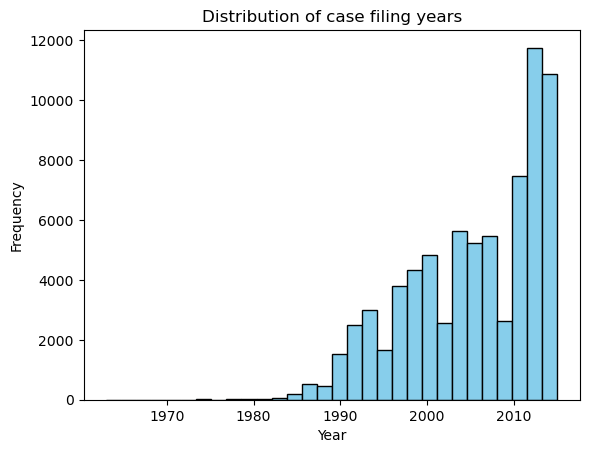

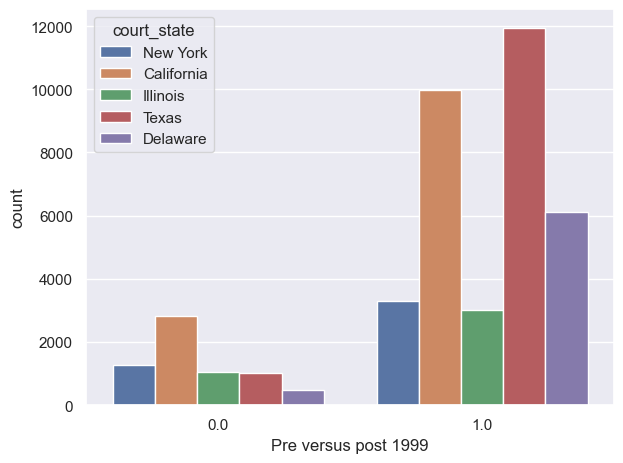

In [25]:
### figures/summary stats for understanding the dataset

# general summary statistics for numeric variables
summary_numeric = grouped_cases[["year_filed", "demand_num"]].describe()
print(summary_numeric)

# create crosstab of jury demand
freq_jury = grouped_cases["jury_demand"].value_counts()
print(freq_jury)
                        
# create a histogram of filing over time
plt.hist(m_cases["year_filed"], bins=30, color='skyblue', edgecolor='black')
# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of case filing years') 
# Display the plot
plt.show()

# create a bar chart of the distribution of cases across year by most filed in states
most_filed_states_id = m_cases["court_state"].value_counts().nlargest(5).index
most_filed_states = m_cases.loc[m_cases["court_state"].isin(most_filed_states_id), :]
list(most_filed_states["court_state"].unique())
sns.set()
ax = sns.countplot(data=most_filed_states, x='post_99', hue='court_state')
ax.set_xlabel('Pre versus post 1999') 
plt.tight_layout()
plt.show()

In [196]:
df.describe()

,case_row_id,pacer_id_x,date_last_filed,year_filed,case_order,demand_num,post_99,date_filed,date_closed,defendant,plaintiff,mediator,witness,other,defendant_M,defendant_F,plaintiff_M,plaintiff_F,mediator_M,mediator_F,witness_M,witness_F,other_M,other_F,male,female,total,number_docs
count,58642.000000,8.896000e+03,2605,58642.000000,58642.000000,57.000000,58642.0,52912,52911,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,56563.000000,58538.000000
mean,38978.414788,1.688099e+05,2009-06-01 20:10:02.533588992,2008.568432,3826.924849,8771.929825,1.0,2009-03-19 16:56:53.305110272,2009-06-01 08:41:51.447525120,3.994166,3.376819,0.036950,0.000566,0.010696,3.111009,0.674098,2.740643,0.486537,0.034333,0.000919,0.000442,0.000124,0.008292,0.001202,5.983187,1.181479,7.531001,69.963955
min,337.000000,3.000000e+00,1999-02-01 00:00:00,1999.000000,1.000000,0.000000,1.0,1996-08-29 00:00:00,1996-08-29 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,20475.250000,5.400925e+04,2007-04-11 00:00:00,2004.000000,433.250000,0.000000,1.0,2005-01-19 00:00:00,2005-04-25 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,15.000000
50%,39005.500000,1.358985e+05,2009-08-19 00:00:00,2010.000000,1095.000000,0.000000,1.0,2010-06-28 00:00:00,2010-09-21 00:00:00,2.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,5.000000,30.000000
75%,56544.750000,2.357320e+05,2012-08-01 00:00:00,2013.000000,3058.000000,0.000000,1.0,2013-06-17 00:00:00,2013-08-23 00:00:00,5.000000,4.000000,0.000000,0.000000,0.000000,4.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,2.000000,9.000000,67.000000
max,74674.000000,1.218702e+06,2016-02-29 00:00:00,2015.000000,90703.000000,500000.000000,1.0,2015-12-31 00:00:00,2016-02-12 00:00:00,308.000000,81.000000,4.000000,3.000000,27.000000,234.000000,58.000000,60.000000,24.000000,4.000000,1.000000,3.000000,1.000000,9.000000,2.000000,322.000000,84.000000,423.000000,8461.000000
std,20587.024118,1.464487e+05,NaN,4.950129,10221.635786,66226.617853,0.0,NaN,NaN,7.349850,3.050888,0.204212,0.032017,0.173901,5.801281,1.470550,2.465358,0.876204,0.194662,0.030307,0.026920,0.011124,0.117515,0.035159,7.239896,1.922052,9.179689,129.712680


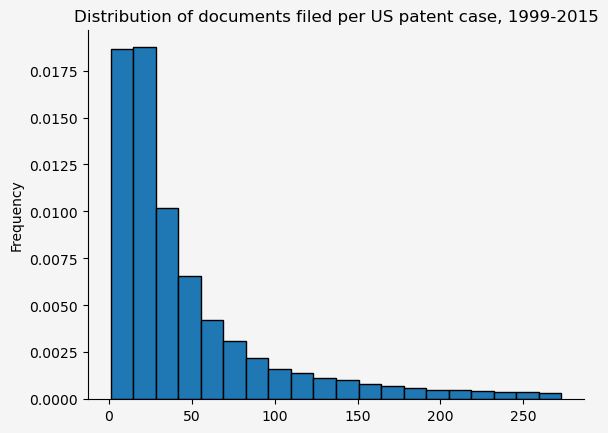

In [424]:
# histogram of the number of documents filed per case
df_hist = df[df["number_docs"] < df["number_docs"].quantile(0.95)]

fig, ax = plt.subplots()
df_hist.plot(
    kind="hist", y="number_docs",
    bins=20, legend=False, density=True, ax=ax, edgecolor = "black"
)
ax.set_facecolor((0.96, 0.96, 0.96))
fig.set_facecolor((0.96, 0.96, 0.96))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Distribution of documents filed per US patent case, 1999-2015")
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/histogram_doc_filings.png", dpi=300, format="png")

<Axes: xlabel='year_range'>

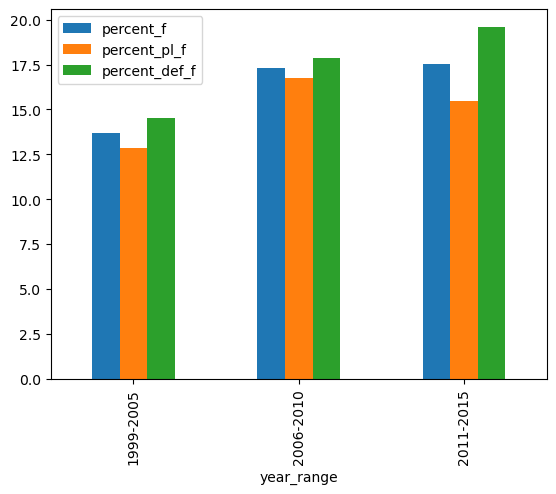

In [59]:
### bar chart of % of lawyers who are women by party type

# collapse dataset over year ranges
df_year = df.drop(df.iloc[:, 0:14], axis=1)
df_year = df_year.drop(["date_filed",	"date_closed", "date_last_filed"], axis=1)
df_year.loc[df_year["year_filed"] <= 2005, "year_range"] = "1999-2005"
df_year.loc[(2006 <= df_year["year_filed"]) & (df_year["year_filed"] <= 2010), "year_range"] = "2006-2010"
df_year.loc[df_year["year_filed"] >= 2011, "year_range"] = "2011-2015"
df_year = df_year.groupby("year_range").agg("sum")
df_year = df_year.reset_index()

# create variables with proportion of female attorneys for each party type
df_year["percent_f"] = 100 * df_year["female"] / (df_year["female"] + df_year["male"])
df_year["percent_pl_f"] = 100 * df_year["plaintiff_F"] / (df_year["plaintiff_F"] + df_year["plaintiff_M"])
df_year["percent_def_f"] = 100 * df_year["defendant_F"] / (df_year["defendant_F"] + df_year["defendant_M"])
# df_year["percent_med_f"] = 100 * df_year["mediator_F"] / (df_year["mediator_F"] + df_year["mediator_M"])
# df_year["percent_wit_f"] = 100 * df_year["witness_F"] / (df_year["witness_F"] + df_year["witness_M"])
# df_year["percent_other_f"] = 100 * df_year["other_F"] / (df_year["other_F"] + df_year["other_M"])

df_year = df_year.drop(df_year.iloc[:, 1:28], axis=1)

# df_year.plot(x="year_range", kind="bar", stacked=False)

In [61]:
Row_list =[]

# iterate over each row
for index, rows in df_year.iterrows():
    # Create list for the current row
    my_list =[rows.percent_f, rows.percent_def_f, rows.percent_pl_f]
    
    # append the list to the final list
    Row_list.append(my_list)

print(Row_list)
df_year

[[13.693342431036163, 14.509728745327326, 12.827724967663785], [17.309679641749913, 17.85009129911967, 16.727929181982294], [17.518561205071162, 19.600088822154785, 15.458425815263787]]


,year_range,percent_f,percent_pl_f,percent_def_f
0,1999-2005,13.693342,12.827725,14.509729
1,2006-2010,17.309680,16.727929,17.850091
2,2011-2015,17.518561,15.458426,19.600089


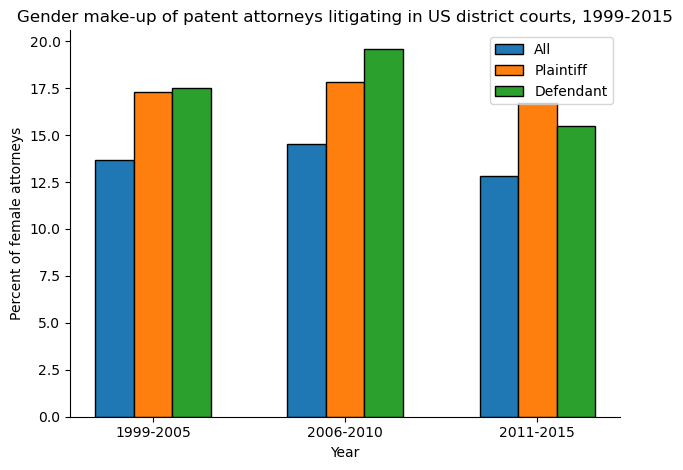

In [426]:
labels = ["All", "Plaintiff", "Defendant"]

Row_list =[]

# iterate over each row
for index, rows in df_year.iterrows():
    # Create list for the current row
    my_list =[rows.percent_f, rows.percent_def_f, rows.percent_pl_f]
    # append the list to the final list
    Row_list.append(my_list)

range_1 = Row_list[0]
range_2 = Row_list[1]
range_3 = Row_list[2]

fig, ax = plt.subplots()

index = np.arange(3)
width = 0.2

rects1 = ax.bar(
    index, range_1, width, label='All', edgecolor="black"
)

rects2 = ax.bar(
    index + width, range_2, width, label='Plaintiff', edgecolor="black"
)

rects3 = ax.bar(
    index + width*2, range_3, width, label='Defendant', edgecolor="black"
)

ax.set_xlabel('Year')
ax.set_ylabel('Percent of female attorneys')
ax.set_title('Gender make-up of patent attorneys litigating in US district courts, 1999-2015')
ax.set_xticks(index + width )
ax.set_xticklabels(('1999-2005', '2006-2010', '2011-2015'))
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/bar_attorney_gender.png", dpi=300, format="png")

In [151]:
### relationship between the proportion of court filings and the proportion of lawyers in a court who a women

df_court = df.drop(["date_filed", "date_closed", "date_last_filed"], axis=1)
df_court.loc[df_court["year_filed"] <= 2005, "year_range"] = "1999-2005"
df_court.loc[(2006 <= df_court["year_filed"]) & (df_court["year_filed"] <= 2010), "year_range"] = "2006-2010"
df_court.loc[df_court["year_filed"] >= 2011, "year_range"] = "2011-2015"
df_court = df_court.groupby(["court_state", "court_region", "year_range"]).agg("sum")
df_court = df_court.reset_index()

# create variable showing proportion of case filings made in year range in a given court
df_court.loc[df_court["year_range"] == "1999-2005", "total_filings"] = df_court[df_court["year_range"] == "1999-2005"]["post_99"].sum(axis=0)
df_court.loc[df_court["year_range"] == "2006-2010", "total_filings"] = df_court[df_court["year_range"] == "2006-2010"]["post_99"].sum(axis=0)
df_court.loc[df_court["year_range"] == "2011-2015", "total_filings"] = df_court[df_court["year_range"] == "2011-2015"]["post_99"].sum(axis=0)
df_court["percent_filings"] = 100* df_court["post_99"] / df_court["total_filings"] 

df_court["percent_female"] = 100 * df_court["female"] / (df_court["female"] + df_court["male"])

df_court.head(10)
df_court.loc[df_court["percent_female"].isna(), "percent_female"] = 0

court_state             0
court_region            0
year_range              0
case_row_id             0
case_number_x           0
pacer_id_x              0
case_name_x             0
court_name_x            0
assigned_to             0
referred_to             0
case_cause              0
jurisdictional_basis    0
demand                  0
jury_demand             0
lead_case               0
related_case            0
settlement              0
year_filed              0
case_order              0
courthouse              0
demand_num              0
demand_party            0
court_code              0
post_99                 0
defendant               0
plaintiff               0
mediator                0
witness                 0
other                   0
defendant_M             0
defendant_F             0
plaintiff_M             0
plaintiff_F             0
mediator_M              0
mediator_F              0
witness_M               0
witness_F               0
other_M                 0
other_F     

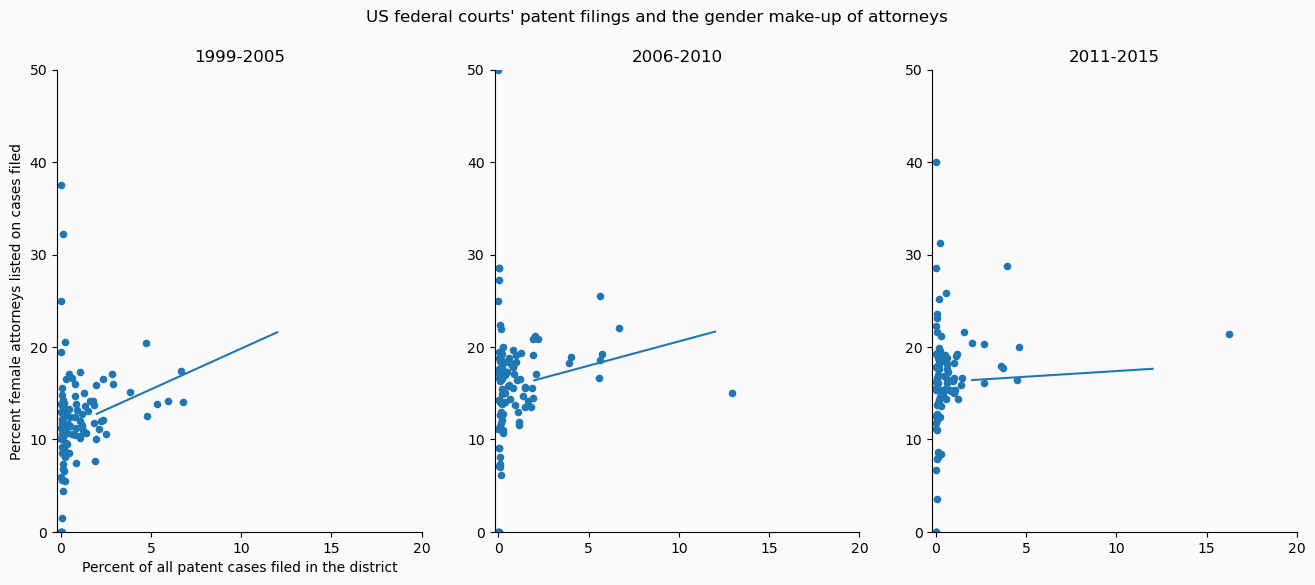

In [428]:
def single_scatter_plot(df, year, ax):
    """
    This function creates a single year's percent filings to percent female plot
    """
    # Filter data to keep only the data of interest
    _df = df_court[df_court['year_range'] == year]
    _df.plot(
        kind="scatter", x="percent_filings", y="percent_female", ax=ax
    )

    lr = LinearRegression()
    X = _df["percent_filings"].values.reshape(-1, 1)# you can feed -1 as one of the values in reshape and 
                                                # let numpy figure out that dimension
    y = _df["percent_female"].values.reshape(-1, 1) # the output is an array
    lr.fit(X, y)

    x = np.linspace(2.0, 12.0).reshape(-1, 1)
    y_pred = lr.predict(x)
    ax.plot(x, y_pred)

    return ax

# Create initial plot
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

for (i, year) in enumerate(df_court.year_range.unique()):
    single_scatter_plot(df, year, ax[i])
    ax[i].set_title(str(year))

bgcolor = (250/255, 250/255, 250/255)
fig.set_facecolor(bgcolor)
for (i, _ax) in enumerate(ax):
    # Label with words
    if i == 0:
        _ax.set_xlabel("Percent of all patent cases filed in the district")
    else:
        _ax.set_xlabel("")

    # Turn off right and top axis lines
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)

    # Don't use such a white background color
    _ax.set_facecolor(bgcolor)

    # Change bounds
    _ax.set_ylim((0, 50))
    _ax.set_xlim((-0.2, 20))
 
    # Change ticks
    # xticks = [10, 100, 1000, 10000]
    # _ax.set_xticks([np.log(xi) for xi in xticks])
    # _ax.set_xticklabels([str(xi) for xi in xticks])

    # yticks = list(range(5, 32, 5))
    # _ax.set_yticks([np.log(yi) for yi in yticks])
    if i == 0:
        # _ax.set_yticklabels([str(yi) for yi in yticks])
        _ax.set_ylabel("Percent female attorneys listed on cases filed")
    else:
        # _ax.set_yticklabels([])
        _ax.set_ylabel("")

ax[0].set_zorder(1)
fig.suptitle("US federal courts' patent filings and the gender make-up of attorneys")
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/scatter_filings_gender.png", dpi=300, format="png")

In [444]:
# percent filings in top 10 courts by year

df_top = df.drop(["date_filed", "date_closed", "date_last_filed"], axis=1)
df_top = df_top.groupby(["court_state", "court_region", "year_filed"]).agg("sum")
df_top = df_top.reset_index()
df_top = df_top.drop(df_top.iloc[:, 3:22], axis=1)

# create variable showing proportion of case filings made in year range in a given court
for year in range(1999, 2016):
    df_top.loc[df_top["year_filed"] == year, "total_filings"] = df_top[df_top["year_filed"] == year]["post_99"].sum(axis=0)

# create new dataset with top 10 courts, bottom 10 courts
df_top_years = df_top[df_top["year_filed"] == 1999].nlargest(10, "post_99")
for year in range(2000, 2016):
    _df = df_top[df_top["year_filed"] == year].nlargest(10, "post_99")
    df_top_years = pd.concat([df_top_years, _df], axis = 0)
df_top_years["top10"] = 1

for year in range(1999, 2016):
    _df = df_top[df_top["year_filed"] == year].nsmallest(84, "post_99")
    df_top_years = pd.concat([df_top_years, _df], axis = 0)
df_top_years = df_top_years.fillna(0)

df_top_years = df_top_years.drop(df_top_years.iloc[:, 4:23], axis=1)
df_top_years = df_top_years.drop(df_top_years.iloc[:, 0:2], axis=1)
df_top_years["year_filed"] = df_top_years["year_filed"].astype(int)
df_top_years = df_top_years.groupby(["top10", "year_filed"]).agg({"post_99":"sum", "total_filings": "max"})

df_top_years["percent_filings"] = 100* df_top_years["post_99"] / df_top_years["total_filings"]

# df_top_years

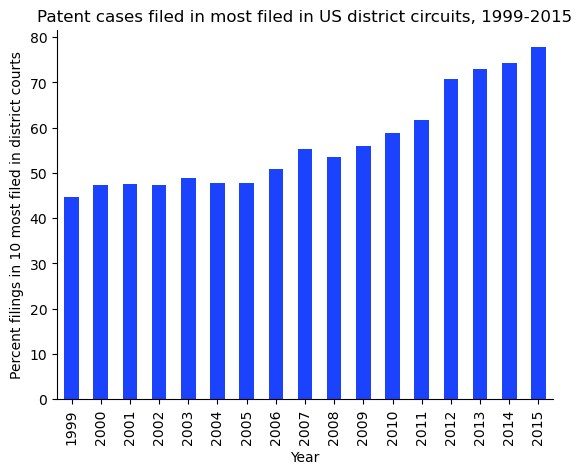

In [446]:
df_top_years = df_top_years.drop(["post_99", "total_filings"], axis=1)
df_top_years = df_top_years.reset_index(level = "top10")
df_top_years = df_top_years[df_top_years["top10"] == 1]
df_top_years = df_top_years.drop("top10", axis=1)

fig, ax = plt.subplots()

df_top_years["percent_filings"].plot(kind="bar", ax=ax, color="#1b42fc")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Year")
ax.set_ylabel("Percent filings in 10 most filed in district courts")
ax.set_title("Patent cases filed in most filed in US district circuits, 1999-2015")
plt.savefig("C:/Users/schwa/OneDrive/Desktop/School/ECO225/Results/bar_top10.png", dpi=200, format="png", bbox_inches="tight")